# Model Building Notebook


Clouds formation happen in many different ways but the margin between them are obscure. This makes it challenging to build Algorithms to separate cloud features. Humans, however, is extremely good at finding and detecting cloud features.


> `Shallow clouds are vital in determining the Earth's climate. They’re also difficult to understand and to represent in climate models.Researchers at max plank. By classifying the cloud formations we can gain physical understanding of them and helps us to build better climate models`

In this Notebook we will build a model to classify cloud organization patterns from satellite images, which could increase our understanding on how clouds are shaping our climate.

## Lets Import some of the important Libraries we need

In [ ]:
import os, glob
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import multiprocessing
from copy import deepcopy
from sklearn.metrics import precision_recall_curve, auc
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion,CenterCrop
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm
from numpy.random import seed
seed(10)
from tensorflow import random
random.set_seed(10)
%matplotlib inline

Here in this kernel i got 0.61 after trying InceptionResNetV2
So lets use this pre-trained NN

In [ ]:
!pip install -U keras-applications
import keras_applications
import keras
import tensorflow as tf
from keras_applications.resnext import ResNeXt101

     |████████████████████████████████| 51kB 2.7MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)

Mounted at /content/drive/


In [ ]:
Train_imgs_folder = '/content/drive/MyDrive/Cloud_model_prediction/train_images/'
Test_imgs_folder = '/content/drive/MyDrive/Cloud_model_prediction/test_images/'

num_cores = multiprocessing.cpu_count()

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Cloud_model_prediction/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


**One Hot Encoding** our classes for our model to interpret them

In [ ]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]

train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])

classes = train_df['Class'].unique()

train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()

for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)

train_df.head()

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Fish, Flower}",1,1,0,0
1,002be4f.jpg,"{Fish, Sugar, Flower}",1,1,1,0
2,0031ae9.jpg,"{Fish, Sugar, Flower}",1,1,1,0
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1
4,003994e.jpg,"{Fish, Gravel, Sugar}",1,0,1,1


In [ ]:
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df.iloc[:, 2:].values)}

Stratified split of the Training data to balance the distribution of classes

In [ ]:
train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.1, 
                                        stratify=train_df['Class'].map(lambda x: str(sorted(list(x)))),
                                        random_state=42)

Lets Create a Generator Class which helps us to generate data and send the data into small batches as our data is quite large and our model performs better this way.

In [ ]:
class DataGenenerator(Sequence):
    
    def __init__(self, images_list=None, folder_imgs=Train_imgs_folder, 
                 batch_size=32, shuffle=True, augmentation=None,
                 resized_height=224, resized_width=224, num_channels=3):
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        self.folder_imgs = folder_imgs
        self.len = len(self.images_list) // self.batch_size
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.num_channels = num_channels
        self.num_classes = 4
        self.is_test = not 'train' in folder_imgs
        if not shuffle and not self.is_test:
            self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

    def __len__(self):
        return self.len
    
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __getitem__(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y = np.empty((self.batch_size, self.num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(self.folder_imgs, image_name)
            img = cv2.resize(cv2.imread(path), (self.resized_height, self.resized_width)).astype(np.float32)
            if not self.augmentation is None:
                augmented = self.augmentation(image=img)
                img = augmented['image']
            X[i, :, :, :] = img/255.0
            if not self.is_test:
                y[i, :] = img_2_ohe_vector[image_name]
        return X, y

    def get_labels(self):
        if self.shuffle:
            images_current = self.images_list[:self.len*self.batch_size]
            labels = [img_2_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

## `Data Augmentation`

Augmentation of data is useful when you want to generate more instances from exsisting data and increase our F1 score. This method also helps the model to identify patterns more efficiently but Data Augmentation should be done only when there is insufficient data for the model to train on 

In [ ]:
albumentations_train = Compose([
    VerticalFlip(), HorizontalFlip(), Rotate(limit=20), GridDistortion()
], p=1)

Generator instances

In [ ]:
Data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train)
Data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False)
Data_generator_val = DataGenenerator(val_imgs, shuffle=False)

## `PR-AUC-based Callback`

**The callback would be used:**

- To estimate AUC under precision recall curve for each class,
- To early stop after 5 epochs of no improvement in mean PR AUC,
- To save a model with the best PR AUC in validation,
- To reduce learning rate on PR AUC plateau.

In [ ]:
class PrAucCallback(Callback):
    def __init__(self, data_generator, num_workers=num_cores, 
                 early_stopping_patience=3, 
                 plateau_patience=3, reduction_rate=0.5,
                 stage='train', checkpoints_path='/content/drive/MyDrive/Cloud_model_prediction/checkpoints/'):
        super(Callback, self).__init__()
        self.data_generator = data_generator
        self.num_workers = num_workers
        self.class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
        self.history = [[] for _ in range(len(self.class_names) + 1)] 
        self.early_stopping_patience = early_stopping_patience
        self.plateau_patience = plateau_patience
        self.reduction_rate = reduction_rate
        self.stage = stage
        self.best_pr_auc = -float('inf')
        if not os.path.exists(checkpoints_path):
            os.makedirs(checkpoints_path)
        self.checkpoints_path = checkpoints_path
        
    def compute_pr_auc(self, y_true, y_pred):
        pr_auc_mean = 0
        print(f"\n{'#'*30}\n")
        for class_i in range(len(self.class_names)):
            precision, recall, _ = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
            pr_auc = auc(recall, precision)
            pr_auc_mean += pr_auc/len(self.class_names)
            print(f"PR AUC {self.class_names[class_i]}, {self.stage}: {pr_auc:.3f}\n")
            self.history[class_i].append(pr_auc)        
        print(f"\n{'#'*20}\n PR AUC mean, {self.stage}: {pr_auc_mean:.3f}\n{'#'*20}\n")
        self.history[-1].append(pr_auc_mean)
        return pr_auc_mean
              
    def is_patience_lost(self, patience):
        
        if len(self.history[-1]) > patience:
            
            best_performance = max(self.history[-1][-(patience + 1):-1])
            return best_performance == self.history[-1][-(patience + 1)] and best_performance >= self.history[-1][-1]    
              
    def early_stopping_check(self, pr_auc_mean):
        
        if self.is_patience_lost(self.early_stopping_patience):
            
            self.model.stop_training = True    
              
    def model_checkpoint(self, pr_auc_mean, epoch):
        
        if pr_auc_mean > self.best_pr_auc:
            
            for checkpoint in glob.glob(os.path.join(self.checkpoints_path, 'classifier_epoch_*')):
                
                os.remove(checkpoint)
        
        self.best_pr_auc = pr_auc_mean
        self.model.save(os.path.join(self.checkpoints_path, f'classifier_epoch_{epoch}_val_pr_auc_{pr_auc_mean}.h5'))              
        print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
              
    def reduce_lr_on_plateau(self):
        if self.is_patience_lost(self.plateau_patience):
            new_lr = float(keras.backend.get_value(self.model.optimizer.lr)) * self.reduction_rate
            keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\n{'#'*20}\nReduced learning rate to {new_lr}.\n{'#'*20}\n")
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_generator(self.data_generator, workers=self.num_workers)
        y_true = self.data_generator.get_labels()
       
        pr_auc_mean = self.compute_pr_auc(y_true, y_pred)
              
        if self.stage == 'val':
            
            self.early_stopping_check(pr_auc_mean)

            self.model_checkpoint(pr_auc_mean, epoch)

            self.reduce_lr_on_plateau()            
        
    def get_pr_auc_history(self):
        return self.history

> ***Callback instances***

`These callbacks major play is to store the PR AUC MEAN for each cloud formation type.`

In [ ]:
Train_metric_callback = PrAucCallback(Data_generator_train_eval)
Val_callback = PrAucCallback(Data_generator_val, stage='val')

## Defining the Classifier Model

> As mentioned earlier we use `InceptionResNetV2` pretrained on ImageNet

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

def get_model():
  
    base_model = model = ResNeXt101(..., backend=tf.keras.backend, layers=tf.keras.layers, weights = 'imagenet', models=tf.keras.models, utils=tf.keras.utils)
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

178176000/178173608 [==============================] - 2s 0us/step


> Tuning the Parameters of the model

`Kick-starting the Training...`

In [ ]:
for base_layer in model.layers[:-1]:
    base_layer.trainable = False
    
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy')

history_8 = model.fit_generator(generator = Data_generator_train,
                              validation_data = Data_generator_val,
                              epochs=2,
                              callbacks=[Train_metric_callback, Val_callback],
                              workers=num_cores,
                              verbose = 2
                             )




/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
155/155 - 4691s - loss: 2.9533 - val_loss: 2.9573


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



##############################

PR AUC Fish, train: 0.496

PR AUC Flower, train: 0.520

PR AUC Sugar, train: 0.670

PR AUC Gravel, train: 0.534


####################
 PR AUC mean, train: 0.555
####################


##############################

PR AUC Fish, val: 0.497

PR AUC Flower, val: 0.528

PR AUC Sugar, val: 0.655

PR AUC Gravel, val: 0.479


####################
 PR AUC mean, val: 0.540
####################


####################
Saved new checkpoint
####################

Epoch 2/2
155/155 - 4379s - loss: 2.9524 - val_loss: 2.9563

##############################

PR AUC Fish, train: 0.500

PR AUC Flower, train: 0.545

PR AUC Sugar, train: 0.671

PR AUC Gravel, train: 0.537


####################
 PR AUC mean, train: 0.563
####################



In [ ]:
model.save('Clouds_pattern_prediction_cycle_1.h5')

In [ ]:
from keras.models import load_model

model_cycle_2 = load_model('/content/drive/MyDrive/Cloud_model_prediction/Clouds_pattern_prediction_cycle_1.h5')
print('model loaded')

model loaded


In [ ]:
model_cycle_2.fit_generator(generator = Data_generator_train,
                              validation_data = Data_generator_val,
                              epochs=4,
                              callbacks=[Train_metric_callback, Val_callback],
                              workers=num_cores,
                              verbose = 0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



##############################

PR AUC Fish, train: 0.504

PR AUC Flower, train: 0.569

PR AUC Sugar, train: 0.672

PR AUC Gravel, train: 0.539


####################
 PR AUC mean, train: 0.571
####################


##############################

PR AUC Fish, val: 0.500

PR AUC Flower, val: 0.565

PR AUC Sugar, val: 0.659

PR AUC Gravel, val: 0.482


####################
 PR AUC mean, val: 0.551
####################


####################
Saved new checkpoint
####################


##############################

PR AUC Fish, train: 0.509

PR AUC Flower, train: 0.588

PR AUC Sugar, train: 0.674

PR AUC Gravel, train: 0.542


####################
 PR AUC mean, train: 0.578
####################


##############################

PR AUC Fish, val: 0.503

PR AUC Flower, val: 0.582

PR AUC Sugar, val: 0.662

PR AUC Gravel, val: 0.485


####################
 PR AUC mean, val: 0.558
####################


####################
Saved new checkpoint
####################


#####################

In [ ]:
model_cycle_2.save('Clouds_pattern_prediction_cycle_2.h5')

In [ ]:
from keras.models import load_model

model_cycle_3 = load_model('/content/drive/MyDrive/Cloud_model_prediction/Clouds_pattern_prediction_cycle_2.h5')
print('Model loaded')

Model loaded


In [ ]:
history_24 = model_cycle_3.fit_generator(generator = Data_generator_train,
                              validation_data = Data_generator_val,
                              epochs=4,
                              callbacks=[Train_metric_callback, Val_callback],
                              workers=num_cores,
                              verbose = 2
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
155/155 - 4241s - loss: 2.9474 - val_loss: 2.9515


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



##############################

PR AUC Fish, train: 0.530

PR AUC Flower, train: 0.623

PR AUC Sugar, train: 0.679

PR AUC Gravel, train: 0.549


####################
 PR AUC mean, train: 0.595
####################


##############################

PR AUC Fish, val: 0.522

PR AUC Flower, val: 0.612

PR AUC Sugar, val: 0.676

PR AUC Gravel, val: 0.493


####################
 PR AUC mean, val: 0.576
####################


####################
Saved new checkpoint
####################

Epoch 2/4
155/155 - 4035s - loss: 2.9471 - val_loss: 2.9507

##############################

PR AUC Fish, train: 0.539

PR AUC Flower, train: 0.628

PR AUC Sugar, train: 0.680

PR AUC Gravel, train: 0.551


####################
 PR AUC mean, train: 0.600
####################


##############################

PR AUC Fish, val: 0.531

PR AUC Flower, val: 0.617

PR AUC Sugar, val: 0.677

PR AUC Gravel, val: 0.496


####################
 PR AUC mean, val: 0.580
####################


####################
Saved

In [ ]:
model_cycle_3.save('Clouds_pattern_prediction_cycle_3.h5')

In [ ]:
history_24.history.keys()

In [ ]:
df_6_to_10_epoch_history = pd.DataFrame(history_24.history, columns=['loss','val_loss'])

In [ ]:
df_6_to_10_epoch_history

,loss,val_loss
0,2.947442,2.951486
1,2.947054,2.950657
2,2.946044,2.949815
3,2.944864,2.948971


In [ ]:
df_6_to_10_epoch_history.to_csv('6_to_10_epoch_history.csv')

In [ ]:
from keras.models import load_model

try : 
  model_cycle_4 = load_model('/content/drive/MyDrive/Cloud_model_prediction/Clouds_pattern_prediction_cycle_3.h5')
except :
  print('model not loaded')

In [ ]:
history_32 = model_cycle_4.fit_generator(generator = Data_generator_train,
                              validation_data = Data_generator_val,
                              epochs = 3,
                              callbacks=[Train_metric_callback, Val_callback],
                              workers=num_cores,
                              verbose = 4
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



##############################

PR AUC Fish, train: 0.558

PR AUC Flower, train: 0.639

PR AUC Sugar, train: 0.684

PR AUC Gravel, train: 0.556


####################
 PR AUC mean, train: 0.609
####################


##############################

PR AUC Fish, val: 0.546

PR AUC Flower, val: 0.628

PR AUC Sugar, val: 0.687

PR AUC Gravel, val: 0.504


####################
 PR AUC mean, val: 0.591
####################


####################
Saved new checkpoint
####################

Epoch 2/3

##############################

PR AUC Fish, train: 0.563

PR AUC Flower, train: 0.642

PR AUC Sugar, train: 0.687

PR AUC Gravel, train: 0.557


####################
 PR AUC mean, train: 0.612
####################


##############################

PR AUC Fish, val: 0.551

PR AUC Flower, val: 0.631

PR AUC Sugar, val: 0.690

PR AUC Gravel, val: 0.506


####################
 PR AUC mean, val: 0.595
####################


####################
Saved new checkpoint
####################

Epoch 3/3

#

In [ ]:
model_cycle_4.save('Clouds_pattern_prediction_cycle_4.h5')

#### Sorry for the chaotic code representation above. `My Model took a total of 32 hours to Train`, i cant let my system to run continously, i had to refrain to train 2 to 4 epochs a day and save the model so i can import the updated model with updates weights and biases next day to train further for many epochs. Each epoch on an average took 3hrs to complete..

> I repeated this saving and reloading process for 4 days and finally stopped   at 12th epoch.

In [ ]:
history_32.history.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
df_11_to_13_epoch_history = pd.DataFrame(history_32.history, columns = ['loss', 'val_loss'])

In [ ]:
df_11_to_13_epoch_history.head()

,loss,val_loss
0,2.944255,2.948088
1,2.943687,2.947266
2,2.942953,2.946455


In [ ]:
df_11_to_13_epoch_history.to_csv('11_to_13_epoch_history.csv')

## Visualizing the Train and Validation PR AUC

In [ ]:
Val_callback.get_pr_auc_history()

[[0.5455504781318627, 0.5511923585101918, 0.5556760416139627],
 [0.6280205709844211, 0.6309480195660102, 0.6338317433158945],
 [0.6869865992755367, 0.6901667808170404, 0.692515815776749],
 [0.5037291058236404, 0.5064504216324193, 0.5090547386696224],
 [0.5910716885538653, 0.5946893951314154, 0.5977695848440572]]

In [ ]:
Pr_auc_train_hist = np.array([[0.496, 0.504, 0.509, 0.515, 0.522, 0.530, 0.539, 0.546, 0.554, 0.5584109520819457, 0.5627039683547901, 0.5662697605767923],
                                  [0.520, 0.569, 0.588, 0.603, 0.614, 0.623, 0.628, 0.633, 0.636, 0.6392501591060451, 0.6420529288571113, 0.6450000486834482],
                                  [0.670, 0.672, 0.674, 0.676, 0.678, 0.679, 0.680, 0.682, 0.683, 0.6839466569763313, 0.6870197417325963, 0.6895516164352611],
                                  [0.534, 0.539, 0.542, 0.544, 0.547, 0.549, 0.551, 0.552, 0.554, 0.5556204194713265, 0.5570217865449805, 0.5583902528521053],
                                  [0.555, 0.571, 0.578, 0.585, 0.590, 0.595, 0.600, 0.603, 0.607, 0.6093070469089121, 0.6121996063723696, 0.6148029196369017]])

Pr_auc_val_hist = np.array([[0.497, 0.500, 0.503, 0.507, 0.513, 0.522, 0.531, 0.535, 0.541, 0.5455504781318627, 0.5511923585101918, 0.5556760416139627],
                                [0.528, 0.565, 0.582, 0.594, 0.605, 0.612, 0.617, 0.620, 0.624, 0.6280205709844211, 0.6309480195660102, 0.6338317433158945],
                                [0.655, 0.659, 0.662, 0.667, 0.672, 0.676, 0.677, 0.682, 0.685, 0.6869865992755367, 0.6901667808170404, 0.692515815776749],
                                [0.479, 0.482, 0.485, 0.487, 0.490, 0.493, 0.496, 0.498, 0.501, 0.5037291058236404, 0.5064504216324193, 0.5090547386696224],
                                [0.540, 0.551, 0.558, 0.564, 0.570, 0.576, 0.580, 0.584, 0.588, 0.5910716885538653, 0.5946893951314154, 0.5977695848440572]])



PR AUC PLOT

In [ ]:
def plot_dots(ax, arr, color):
  ax.scatter(list(range(1, len(arr) + 1)), arr, color = color)
  ax.plot(list(range(1, len(arr) + 1)), arr)

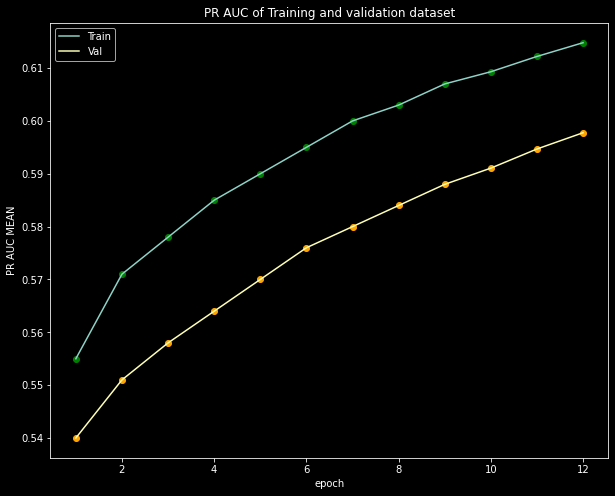

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize = (10,8))
plot_dots(plt, Pr_auc_train_hist[-1], color = 'g')
plot_dots(plt, Pr_auc_val_hist[-1], color = 'orange')

plt.xlabel('epoch')
plt.ylabel('PR AUC MEAN')
plt.legend(['Train', 'Val'])
plt.title('PR AUC of Training and validation dataset')
plt.savefig('pr_auc_hist_dark.png')

`There is a steady increase in Mean of PR AUC for both Training and Validation set`


## Now lets Move on to clean the data for plotting the Training and Validation loss

In [ ]:

history = pd.DataFrame({'loss': [2.9533, 2.9524, 0, 0, 0],
                        'val_loss' : [2.9573, 2.9563, 0, 0, 0]})

In [ ]:
history

,loss,val_loss
0,2.9533,2.9573
1,2.9524,2.9563
2,0.0000,0.0000
3,0.0000,0.0000
4,0.0000,0.0000


In [ ]:
history_6_9_epoch = pd.read_csv('/content/drive/MyDrive/Cloud_model_prediction/6_to_10_epoch_history.csv')

history_10_12_epoch = pd.read_csv('/content/drive/MyDrive/Cloud_model_prediction/11_to_13_epoch_history.csv')

In [ ]:
history_6_9_epoch.head()

,Unnamed: 0,loss,val_loss
0,0,2.947442,2.951486
1,1,2.947054,2.950657
2,2,2.946044,2.949815
3,3,2.944864,2.948971


In [ ]:
history_10_12_epoch

,Unnamed: 0,loss,val_loss
0,0,2.944255,2.948088
1,1,2.943687,2.947266
2,2,2.942953,2.946455


In [ ]:
history_till_9 = pd.concat([history, history_6_9_epoch])

In [ ]:
history_till_9  = history_till_9.reset_index()

In [ ]:
history_till_9.columns

Index(['index', 'loss', 'val_loss', 'Unnamed: 0'], dtype='object')

In [ ]:
history_final = pd.concat([history_till_9, history_10_12_epoch]).reset_index()
history_final

,level_0,index,loss,val_loss,Unnamed: 0
0,0,0.0,2.953300,2.957300,NaN
1,1,1.0,2.952400,2.956300,NaN
2,2,2.0,0.000000,0.000000,NaN
3,3,3.0,0.000000,0.000000,NaN
4,4,4.0,0.000000,0.000000,NaN
5,5,0.0,2.947442,2.951486,0.0
6,6,1.0,2.947054,2.950657,1.0
7,7,2.0,2.946044,2.949815,2.0
8,8,3.0,2.944864,2.948971,3.0
9,0,NaN,2.944255,2.948088,0.0


In [ ]:
history_final.drop(['level_0', 'index', 'Unnamed: 0'], axis = 1,inplace = True)

In [ ]:
history_final

,loss,val_loss
0,2.953300,2.957300
1,2.952400,2.956300
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,2.947442,2.951486
6,2.947054,2.950657
7,2.946044,2.949815
8,2.944864,2.948971
9,2.944255,2.948088


In [ ]:
loss_Mark = (history_final['loss'][5] - history_final['loss'][1]) / 4
val_loss_Mark = (history_final['val_loss'][5] - history_final['val_loss'][1]) / 4

train loss cleaning

In [ ]:
history_final['loss'][2] = history_final['loss'][1] + loss_Mark
history_final['loss'][3] = history_final['loss'][2] + loss_Mark
history_final['loss'][4] = history_final['loss'][3] + loss_Mark

Val loss cleaning

In [ ]:
history_final['val_loss'][2] = history_final['val_loss'][1] + val_loss_Mark
history_final['val_loss'][3] = history_final['val_loss'][2] + val_loss_Mark
history_final['val_loss'][4] = history_final['val_loss'][3] + val_loss_Mark

In [ ]:
history_final

,loss,val_loss
0,2.953300,2.957300
1,2.952400,2.956300
2,2.951160,2.955097
3,2.949921,2.953893
4,2.948681,2.952690
5,2.947442,2.951486
6,2.947054,2.950657
7,2.946044,2.949815
8,2.944864,2.948971
9,2.944255,2.948088


In [ ]:
history_final.to_csv('final_history.csv')

In [ ]:
history_final = pd.read_csv('/content/drive/MyDrive/Cloud_model_prediction/final_history.csv')

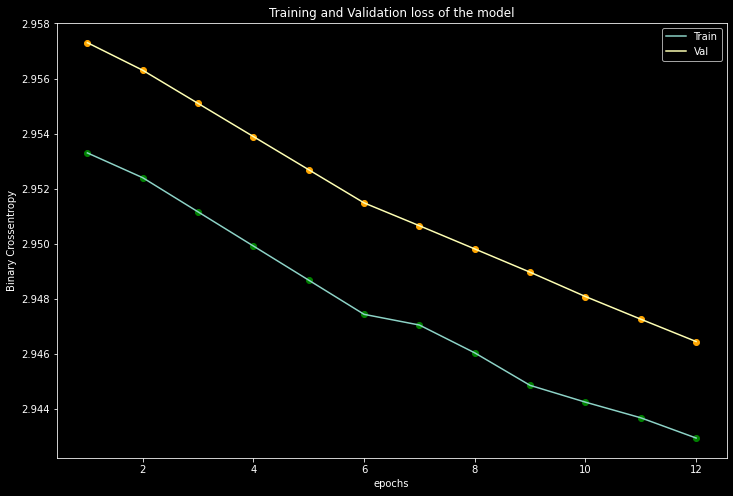

In [ ]:
plt.figure(figsize = (12,8))

plot_dots(plt, history_final['loss'], color = 'g')
plot_dots(plt, history_final['val_loss'], color = 'orange')

plt.xlabel('epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Train', 'Val'])
plt.title('Training and Validation loss of the model')
plt.savefig('T_V_loss.png')

There is steady decrease in loss with increase in epoch which is good.
if we had let the model train for more epochs the loss would definitely converge more to the optimum but thats all i could squeeze with the Time i had and the model already took a lot of time for running a single epoch even on TPU. I stopped training the model at 12 epochs because i was satisfied with the loss curve and got the neccessary information i need in this project.

Determining Thresholds for Precision and Recall

In [ ]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def get_threshold_for_recall(y_true, y_pred, class_i, recall_threshold=0.55, precision_threshold=0.56, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
    i = len(thresholds) - 1
    best_recall_threshold = None
    while best_recall_threshold is None:
        next_threshold = thresholds[i]
        next_recall = recall[i]
        if next_recall >= recall_threshold:
            best_recall_threshold = next_threshold
        i -= 1
        
    
    best_precision_threshold = [thres for prec, thres in zip(precision, thresholds) if prec >= precision_threshold][0]
    
    if plot:
        plt.figure(figsize=(10, 7))
        plt.step(recall, precision, color='r', alpha=0.3, where='post')
        plt.fill_between(recall, precision, alpha=0.3, color='r')
        plt.axhline(y=precision[i + 1])
        recall_for_prec_thres = [rec for rec, thres in zip(recall, thresholds) 
                                 if thres == best_precision_threshold][0]
        plt.axvline(x=recall_for_prec_thres, color='g')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(['PR curve', 
                    f'Precision {precision[i + 1]: .2f} corresponding to selected recall threshold',
                    f'Recall {recall_for_prec_thres: .2f} corresponding to selected precision threshold'])
        plt.title(f'Precision-Recall curve for Class {class_names[class_i]}')
    return best_recall_threshold, best_precision_threshold

In [ ]:
from keras.models import load_model

model_final = load_model('/content/drive/MyDrive/Cloud_model_prediction/Clouds_pattern_prediction_cycle_4.h5')

In [ ]:
y_pred = model_final.predict_generator(Data_generator_val, workers=num_cores)

y_true = Data_generator_val.get_labels()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
for i, class_name in tqdm(enumerate(class_names)):
  print(i, class_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


0 Fish
1 Flower
2 Sugar
3 Gravel



PR AUC FOR FISH

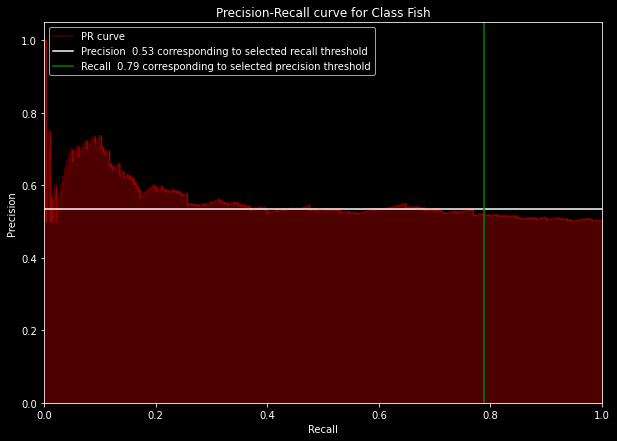

In [ ]:
recall_thresholds['Fish'], precision_thresholds['Fish'] = get_threshold_for_recall(y_true, y_pred, recall_threshold=0.51, precision_threshold=0.52, class_i = 0, plot = True)

PR AUC FOR Flower

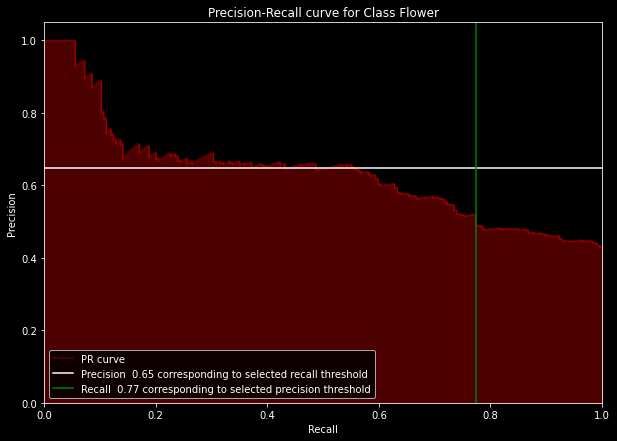

In [ ]:
recall_thresholds["Flower"], precision_thresholds["Fower"] = get_threshold_for_recall(y_true, y_pred, recall_threshold=0.51, precision_threshold=0.52, class_i = 1, plot = True)

PR AUC FOR SUGAR

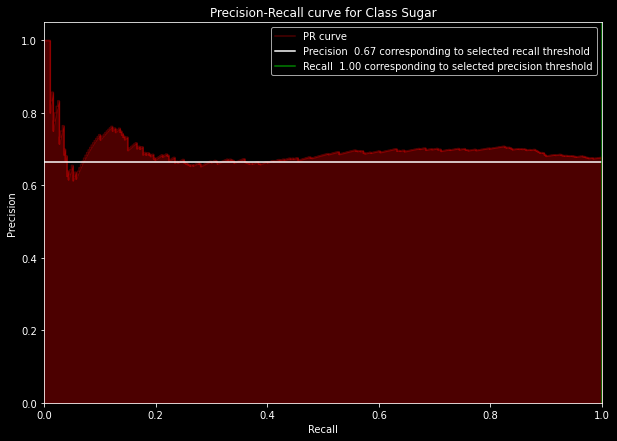

In [ ]:
recall_thresholds["Sugar"], precision_thresholds["Sugar"] = get_threshold_for_recall(y_true, y_pred, recall_threshold=0.4, precision_threshold = 0.52 , class_i = 2, plot = True)

PR AUC FOR GRAVEL

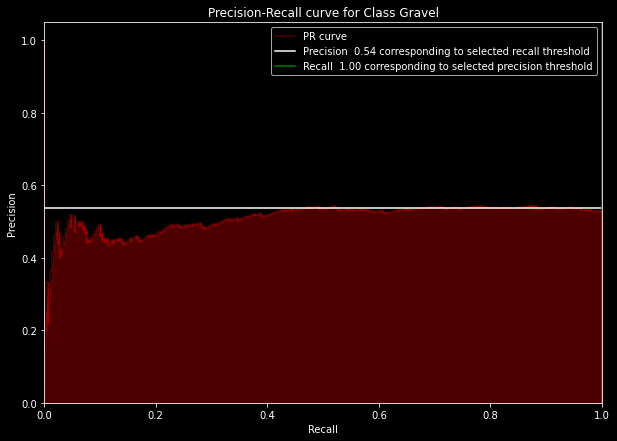

In [ ]:
recall_thresholds['Gravel'], precision_thresholds["Gravel"] = get_threshold_for_recall(y_true, y_pred, recall_threshold=0.51, precision_threshold=0.52, class_i = 3, plot = True)

From the above representations we can come to a conclusion that our model had a high recall rate, which is good and means that it predicted accurately the True positives, As for the precision, Out of all the predcited values our model was right at an average of `61%` of the time. 

> Considering the amount of data and time we had, Our model's performance was not bad.



### This is The End of The Notebook
We have finished our Training and evaluation of the model.

`Hence we have pushed on to remove the haze from climate models and brought some clarity to cloud identification.`